# How to draw bezier curves with SciPy

Have you ever wanted to use a bezier in Python but don't want to install a weird package for it?
Do you really like the numpy-scipy stack but are disappointed that they don't provide bezier utilities?
Well it turns out they do! It's just called **"BPoly".** This notebook will show you how to use it.

## Helpful resources
- https://youtu.be/aVwxzDHniEw: a great youtube video on the topic
- https://en.wikipedia.org/wiki/B%C3%A9zier_curve: Wikipedia
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.BPoly.html: SciPy documentation on BPoly

## What is a bezier curve?

**A bezier curve is an interpolation of points**, which probably explains why `BPoly` is found in `scipy.interpolate`. A characteristic of bezier curves is that they start and end at control points, and the curve in-between is controled by the other control points. In other words, it's trying to approximate the data between those control points, i.e. interpolating them.

There are many ways to interpolate points: linear, quadratic, etc. As it turns out, bezier curves interpolate the points using "Bernstein polynomial" (that's what BPoly stands for!). In a nutshell, they can be thought of as a way to do weighted average between the points, where the coefficients always sum up to 1. So as we go along the curve, we take an average of all the points, giving more importance to the first point, then the second, all the way to the last point. 


In [8]:
from scipy.interpolate import BPoly
import numpy as np
import matplotlib.pyplot as plt

## Basic example

X:
[0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]
sampled_points:
[[0.         0.        ]
 [0.00816446 0.15774894]
 [0.03207465 0.31462312]
 [0.07085581 0.46974778]
 [0.12363318 0.62224814]
 [0.189532   0.77124945]
 [0.2676775  0.91587695]
 [0.35719493 1.05525587]
 [0.45720951 1.18851144]
 [0.56684648 1.31476892]
 [0.68523108 1.43315352]
 [0.81148856 1.54279049]
 [0.94474413 1.64280507]
 [1.08412305 1.7323225 ]
 [1.22875055 1.810468  ]
 [1.37775186 1.87636682]
 [1.53025222 1.92914419]
 [1.68537688 1.96792535]
 [1.84225106 1.99183554]
 [2.         2.        ]]


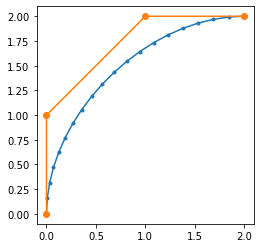

In [6]:
# first we define the control points
control_points = np.array([
    (0, 0), (0, 1), (1, 2), (2, 2)
])

# then a bezier is created as a BPoly object, using the control points and an arbitrary interval
# (in this case just [0, 1])
curve = BPoly(control_points[:, np.newaxis, :], [0, 1])

# then we can generate the points along the curve by calling the BPoly object like a function,
# passing in values in the range [0, 1]. 
X = np.linspace(0, 1, 20)
print('X:')
print(X)
sampled_points = curve(X)
print('sampled_points:')
print(sampled_points)

# the points can then be plotted or use anywhere!
# note that BPoly only generates a set of points, not a completely smooth curve
plt.gca().set_aspect('equal')
plt.plot(*sampled_points.T, '.-')
plt.plot(*control_points.T, '-o')
plt.show()

## Spline example

BPoly can handle a bezier spline, consisting of multiple bezier curves, as well.
We just need some extra tricks. 

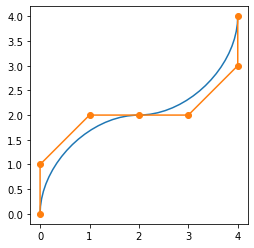

In [4]:
# define the control points again
# we will be using a cubic bezier (k=3), and note that we have the exact number of 
# control points needed (7), considering the middle point is shared between the 2 curves
control_points_spline = np.array([
    (0, 0), (0, 1), (1, 2), (2, 2), (3, 2), (4, 3), (4, 4)
])

# the BPoly is then defined. notice how the control points are sliced such that the middle point is
# duplicated for the 2 intervals. An additional breakpoint is also required ([0, 1, 2]). 
spline = BPoly(np.stack([control_points_spline[0:4], control_points_spline[3:7]], axis=1), [0, 1, 2])

# to use, the interface stays the same! simply call the BPoly like a function. Note how we 
# extend the range to [0, 2]. The point at x=1 will be the middle (4th) control point exactly.
sampled_points_spline = spline(np.linspace(0, 2, 40))
plt.gca().set_aspect('equal')
plt.plot(*sampled_points_spline.T)
plt.plot(*control_points_spline.T, '-o')
plt.show()

## A fancy example

Parameterized and generalized, ready for copy-and-pasting!

In [6]:
"""create a bezier curve/spline as a BPoly object
Args:
    control_points (float[n, 2]): the control points of the bezier curve
    k (int): the order of the curve; defaults to k=3 aka cubic bezier
Return:
    a BPoly object representing the bezier curve
NOTE: The number of control points must agree with the order, such that 
they can be separated into intervals with the same numeber of control points.
E.g. for cubic bezier (k=3), we can have 4, 7, 10, etc control points.
I.e. number of control points % k == 1
"""
def createBezier(control_points, k=3) -> BPoly:
    assert len(control_points)%k == 1
    control_points = np.asarray(control_points)
    c = np.stack([
        control_points[i*k:(i+1)*k+1]
        for i in range((control_points.shape[0]-1)//k)
    ], axis=1)
    x = range(c.shape[1]+1)
    return BPoly(c, x)


"""draw a bezier curve (BPoly object) using matplotlib"""
def drawBezier(bpoly: BPoly):
    X = np.concatenate([np.linspace(bpoly.x[i], bpoly.x[i+1], 20) for i in range(bpoly.x.shape[0]-1)])
    sampled_points = bpoly(X)
    plt.gca().set_aspect('equal')
    plt.plot(*sampled_points.T)
    for i in range(bpoly.c.shape[1]):
        plt.plot(*bpoly.c[:, i, :].T, '-o')
    plt.show()

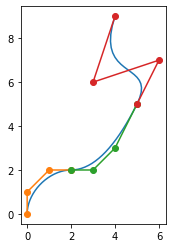

In [7]:
control_points_big = np.array([
    (0, 0), (0, 1), (1, 2), (2, 2), (3, 2), (4, 3), (5, 5), (6, 7), (3, 6), (4, 9)
])
bp = createBezier(control_points_big, 3)
drawBezier(bp)